In [9]:
import joblib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import seaborn as sns
import pybedtools
from pathlib import Path
import h5py
from scipy.stats import spearmanr, pearsonr
from scipy.special import softmax

import mpl_scatter_density # adds projection="scatter_density"
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import cm

from astropy.visualization import LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize

In [10]:
# "Viridis-like" colormap with white background
white_viridis = LinearSegmentedColormap.from_list("white_viridis", [
    (0, "#ffffff"),
    (1e-20, "#440053"),
    (0.2, "#404388"),
    (0.4, "#2a788e"),
    (0.6, "#21a784"),
    (0.8, "#78d151"),
    (1, "#fde624"),
], N=256)

# "Viridis-like" colormap with white background
white_viridis_r = LinearSegmentedColormap.from_list("white_viridis", [
    (0, "#ffffff"),
    (1e-20, "#fde624"),
    (0.4, "#78d151"),
    (0.6, "#21a784"),
    (0.7, "#2a788e"),
    (0.8, "#404388"),
    (1, "#440053"),
], N=256)

prop_cycle = plt.rcParams["axes.prop_cycle"]
colors = prop_cycle.by_key()["color"]

#white_viridis_cm = cm.get_cmap("viridis", 5).with_extremes(under="white")

In [11]:
server = "cbsu"
path = "/home2/ayh8/attribution_scores/all/"
scratch="/Users/adamhe/github/scratch"

all_fp = "merged_windows_all.bed.gz"
shap_fp = "mean_across_folds_all_profile.npz"
pred_fp = "ensemble_all_predictions.h5"
expt_fp = "all_tss_windows_procap_mean.csv.gz"

prom_fp = "all_prom_200_idx.joblib.gz"
enh_fp = "all_enh_idx.joblib.gz"

print(f"scp {server}:{os.path.join(path, shap_fp)} {scratch}")

scp cbsu:/home2/ayh8/attribution_scores/all/mean_across_folds_all_profile.npz /Users/adamhe/github/scratch


In [12]:
prom_idx = joblib.load(Path(scratch, prom_fp))
enh_idx = joblib.load(Path(scratch, enh_fp))
all_bed = pybedtools.BedTool(Path(scratch, all_fp))

In [13]:
shap = np.load(os.path.join(scratch, shap_fp))["arr_0"]
profile_shap = shap.max(axis=1).sum(axis=-1)

In [14]:
pred = np.array(h5py.File(os.path.join(scratch, pred_fp))["track"])
expt = pd.read_csv(os.path.join(scratch, expt_fp), index_col=0, header=None)

In [26]:
def calculate_profile(arr):
    return softmax(arr, axis=1) * arr

In [27]:
expt_clipped = pd.concat([expt.iloc[:, 250:750], expt.iloc[:, 1250:1750]], axis=1)
expt_profile = calculate_profile(expt_clipped).sum(axis=1)
pred_profile = calculate_profile(pred).sum(axis=1)

In [28]:
# prom = 0, enh = 1, neither = 2
is_prom = pd.Series(prom_idx).map(lambda x: 1 if not np.isnan(x) else 0)
is_enh = pd.Series(enh_idx).map(lambda x: 2 if not np.isnan(x) else 0)

cre_class = is_prom + is_enh

In [33]:
df = pd.DataFrame(
    {
        "shap": np.log10(profile_shap),
        "pred": np.log10(pred_profile), 
        "expt": np.log10(expt_profile),
        "cre_class": cre_class
    }
)
only_prom_enh = df[df["cre_class"] != 0]

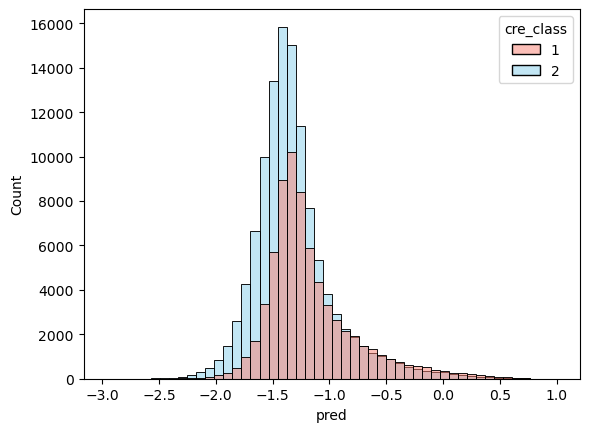

In [40]:
sns.histplot(
    data=only_prom_enh, x="pred",
    hue="cre_class", bins=50, palette=["salmon", "skyblue"]
)
plt.savefig("img/ensemble_all_pred_profile_hist.pdf")

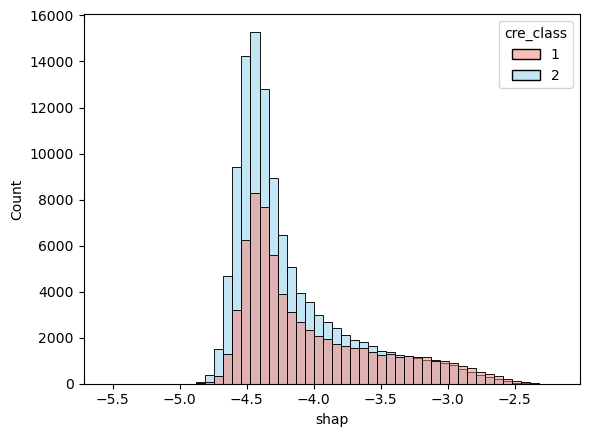

In [41]:
sns.histplot(
    data=only_prom_enh, x="shap",
    hue="cre_class", bins=50, palette=["salmon", "skyblue"]
)
plt.savefig("ensemble_all_shap_profile_hist.pdf")

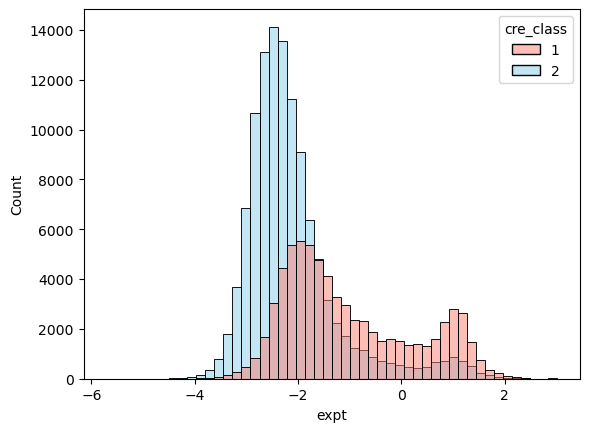

In [39]:
sns.histplot(
    data=only_prom_enh, x="expt",
    hue="cre_class", bins=50, palette=["salmon", "skyblue"]
)
#plt.xlim(-2, 3.5)
plt.savefig("ensemble_all_expt_profile_hist.pdf")

In [249]:
only_prom_enh.expt.max()

3.1448558396396336

<Axes: xlabel='expt', ylabel='shap'>

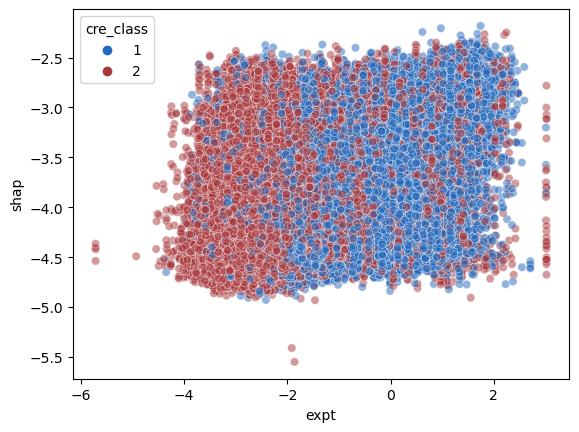

In [43]:
sns.scatterplot(
    data=only_prom_enh, x="expt", y="shap",
    hue=only_prom_enh.cre_class, alpha=0.5, palette="vlag",
)
#plt.xlim(-2.5, 3.5)
#plt.ylim(-0, 2.5)

In [44]:
pearsonr(only_prom_enh["shap"], only_prom_enh["pred"])

PearsonRResult(statistic=0.9073912540382058, pvalue=0.0)

In [45]:
pearsonr(only_prom_enh["shap"], only_prom_enh["expt"])

PearsonRResult(statistic=0.45919595864012097, pvalue=0.0)

In [175]:
only_prom_enh["expt"]

0              NaN
1         0.142595
2         0.891055
3         0.924418
4         1.015353
            ...   
212772    0.745203
212773    1.489640
212774    1.559830
212775    1.626973
212776    1.623357
Name: expt, Length: 184312, dtype: float64

In [141]:
enh = only_prom_enh[only_prom_enh.cre_class == 2]
prom = only_prom_enh[only_prom_enh.cre_class == 1]

/Users/adamhe/miniforge3/envs/plt/lib/python3.12/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/Users/adamhe/miniforge3/envs/plt/lib/python3.12/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


[Text(0.2, 0, ''), Text(2.5, 0, '')]

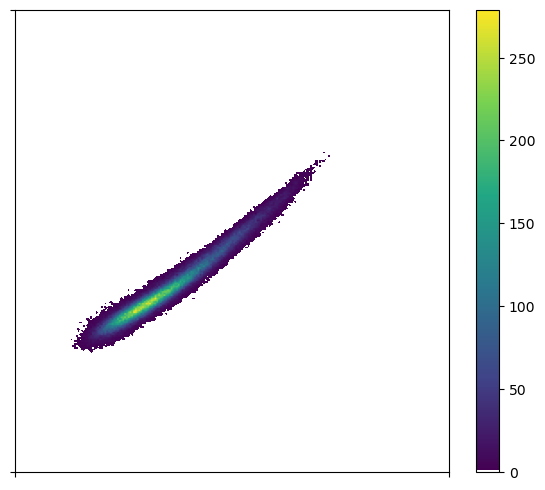

In [143]:
fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(1, 1, 1, projection="scatter_density")
density = ax.scatter_density(enh.shap, enh.pred, cmap=white_viridis)
fig.colorbar(density)#, label="Number of points per pixel")
ax.set_xlim(0.2, 2.5)
ax.set_ylim(0.2, 2.5)
ax.set_yticks([0.2, 2.5])
ax.set_yticklabels(["", ""])
ax.set_xticks([0.2, 2.5])
ax.set_xticklabels(["", ""])

/Users/adamhe/miniforge3/envs/plt/lib/python3.12/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/Users/adamhe/miniforge3/envs/plt/lib/python3.12/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


[Text(0.2, 0, ''), Text(2.5, 0, '')]

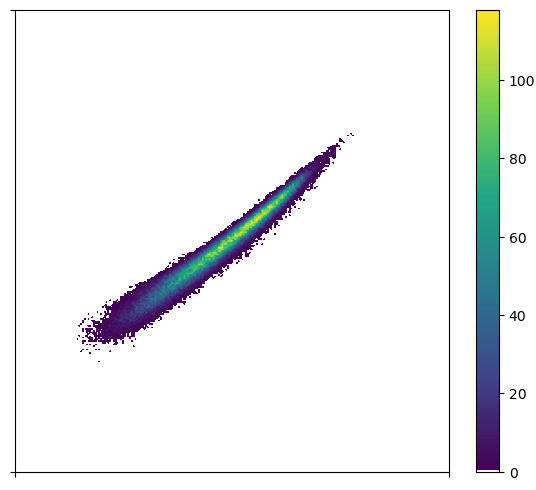

In [144]:
fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(1, 1, 1, projection="scatter_density")
density = ax.scatter_density(prom.shap, prom.pred, cmap=white_viridis)
fig.colorbar(density)#, label="Number of points per pixel")
ax.set_xlim(0.2, 2.5)
ax.set_ylim(0.2, 2.5)
ax.set_yticks([0.2, 2.5])
ax.set_yticklabels(["", ""])
ax.set_xticks([0.2, 2.5])
ax.set_xticklabels(["", ""])